In [1]:
!nvidia-smi

Tue Dec 16 04:04:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Import And Split**


In [2]:
# ============================================================
# 1. Setup
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path
import yaml, shutil, random, xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset paths
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_baseline")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# Custom folder for all outputs
OUTPUT_FOLDER = Path("/kaggle/working/base_yolov12")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1. VOC → YOLO conversion + train/val/test split
# ============================================================
random.seed(42)  # FIX: reproducibility

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.8,0.1,0.1)):  # UPDATED: train 80%, val 10%, test 10%
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.8,0.1,0.1)):  # UPDATED
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    all_pairs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))

    print(f"Found {len(all_pairs)} annotated images total.")

    # OPTION: Oversample minority classes
    # Count per class
    from collections import Counter
    cls_counts = Counter()
    for _, xml_file in all_pairs:
        tree = ET.parse(xml_file)
        for obj in tree.getroot().iter("object"):
            if obj.find("name").text in classes:
                cls_counts[obj.find("name").text] += 1

    min_threshold = 500  # FIX: minimum samples per class
    oversample_pairs = []
    for img_file, xml_file in all_pairs:
        tree = ET.parse(xml_file)
        img_classes = [obj.find("name").text for obj in tree.getroot().iter("object") if obj.find("name").text in classes]
        if any(cls_counts[c] < min_threshold for c in img_classes):
            oversample_pairs.append((img_file, xml_file))  # duplicate minority-class images

    all_pairs.extend(oversample_pairs)  # UPDATED: simple oversampling

    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "val":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.8,0.1,0.1))

# Create data.yaml for YOLOv12
DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready:", DATA)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.7 MB/s eta 0:00:0000:0100:01
Creating new Ultraly

In [3]:
# ============================================================
# 2. Imports and reproducibility
# ============================================================
from tqdm.auto import tqdm
import os, requests, zipfile, cv2, math, glob, random, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import yaml

# FIX: reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


**Train Yolo Baseline**

In [4]:
# ============================================================
# 3. Load dataset YAML & inspect class counts
# ============================================================
yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"  # Update this
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

# Extract class names
class_names = data_yaml["names"]
num_classes = data_yaml["nc"]

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Optional: print class distribution in training set
from pathlib import Path
from collections import Counter

train_labels = list(Path("/kaggle/working/traffic_baseline/yolo_split/train/labels").rglob("*.txt"))
cnt = Counter()
for f in train_labels:
    for line in open(f):
        cls = int(line.split()[0])
        cnt[cls] += 1

print("Class distribution in training set:", cnt)


Number of classes: 9
Class names: ['Rickshaw', 'Bus', 'Truck', 'Bike', 'Mini-truck', 'People', 'Car', 'CNG', 'Cycle']
Class distribution in training set: Counter({6: 50443, 0: 48058, 1: 41654, 5: 31090, 3: 12719, 2: 1069, 8: 553})


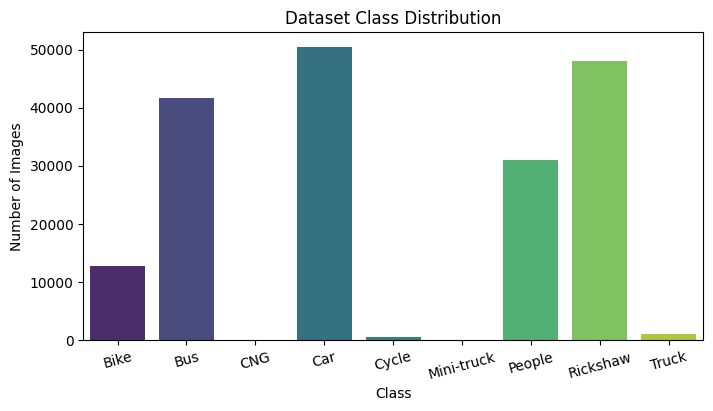

In [5]:
# ============================================================
# 4. Dataset class counts & visualization
# ============================================================
from pathlib import Path

base_path = Path("/kaggle/working/traffic_baseline/yolo_split/train/labels")  # Update this

# Count occurrences of each class in the dataset
class_counts = {name: 0 for name in class_names}

for label_file in base_path.glob("*.txt"):
    with open(label_file, "r") as f:
        for line in f:
            class_idx = int(line.split()[0])  # Get class index
            class_counts[class_names[class_idx]] += 1

# Convert to DataFrame for plotting
class_counts_df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
class_counts_df = class_counts_df.sort_values("Class")  # Sort for consistency

# Plot class distribution
plt.figure(figsize=(8, 4))
sns.barplot(data=class_counts_df, x="Class", y="Count", palette="viridis")
plt.title("Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()


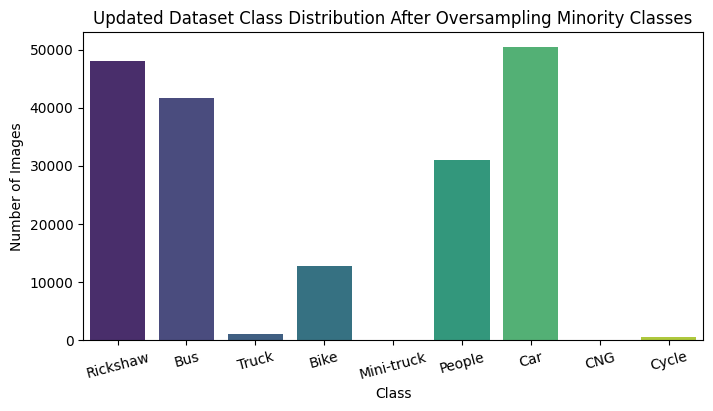

In [6]:
# =================================================================================================
# 5. Oversample minority classes (CNG=7, Mini-truck=4) with simple augmentations then Visualization
# =================================================================================================

# Paths
train_labels_path = "/kaggle/working/traffic_baseline/yolo_split/train/labels"
train_images_path = "/kaggle/working/traffic_baseline/yolo_split/train/images"

# Minority classes to oversample
minority_classes = [4, 7]  # Mini-truck, CNG
oversample_factor = 5      # How many times to duplicate (can adjust)

# Function to apply simple augmentation (flip + rotate)
def augment_image(img_path, save_path, rotate=True, flip=True):
    img = cv2.imread(str(img_path))
    aug_images = []
    if flip:
        aug_images.append(cv2.flip(img, 1))  # horizontal flip
    if rotate:
        rows, cols = img.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)  # rotate 15 degrees
        aug_images.append(cv2.warpAffine(img, M, (cols, rows)))
    # Save augmented images
    for i, aug in enumerate(aug_images):
        aug_filename = save_path.stem + f"_aug{i}.jpg"
        cv2.imwrite(str(train_images_path / aug_filename), aug)
        # Copy corresponding label file
        shutil.copy(str(train_labels_path / save_path.name), str(train_labels_path / aug_filename.replace('.jpg','.txt')))

# Iterate over label files
for label_file in os.listdir(train_labels_path):
    label_path = Path(train_labels_path) / label_file
    with open(label_path, "r") as f:
        lines = f.readlines()
        class_ids = [int(line.split()[0]) for line in lines]
    
    # Check if file contains minority class
    if any(cls in minority_classes for cls in class_ids):
        image_path = Path(train_images_path) / label_file.replace(".txt", ".jpg")
        for _ in range(oversample_factor):
            augment_image(image_path, Path(label_file))

# ============================================================
# Recompute class distribution
# ============================================================
class_counts = {name: 0 for name in class_names}
for label_file in os.listdir(train_labels_path):
    with open(os.path.join(train_labels_path, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx = int(line.split()[0])
            class_counts[class_names[class_idx]] += 1

class_counts_df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])

# Plot updated class distribution
plt.figure(figsize=(8, 4))
sns.barplot(data=class_counts_df, x="Class", y="Count", palette="viridis")
plt.title("Updated Dataset Class Distribution After Oversampling Minority Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()


In [7]:
# ============================================================
# 6. Analyze Class Distribution & Compute Target Counts
# ============================================================
import os
import collections

# Define paths
label_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

# Count labels per class
class_counts = collections.defaultdict(int)

# Read label files
for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID (YOLO format)
            class_counts[class_id] += 1

# Print class distribution
print("Class Distribution Before Balancing:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

# Compute min and max class counts
target_min = min(class_counts.values())
target_max = max(class_counts.values())
print(f"\nTarget count for undersampling (min class): {target_min}")
print(f"Target count for oversampling (max class): {target_max}")


Class Distribution Before Balancing:
Class 0: 48058 images
Class 1: 41654 images
Class 2: 1069 images
Class 3: 12719 images
Class 5: 31090 images
Class 6: 50443 images
Class 8: 553 images

Target count for undersampling (min class): 553
Target count for oversampling (max class): 50443


In [8]:
# ============================================================
# 7. Undersample Majority Class (Class 0) to Balance Dataset
# ============================================================
import shutil
import random
import os

# Define paths
train_images_dir = "/kaggle/working/traffic_baseline/yolo_split/train/images"
train_labels_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

# Target count (smallest class count)
target_count = min(class_counts.values())  # 503 in this case

# Get all Class 0 files
class_0_files = []
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            if int(line.split()[0]) == 0:  # Check if it's Class 0
                class_0_files.append(lbl_file)
                break  # Only need to check one occurrence per file

# Randomly select Class 0 files to keep
files_to_keep = set(random.sample(class_0_files, target_count))
files_removed = []

# Remove extra files (move to backup)
backup_dir = "/kaggle/working/removed_samples"
os.makedirs(backup_dir, exist_ok=True)

for lbl_file in class_0_files:
    if lbl_file not in files_to_keep:
        img_file = lbl_file.replace(".txt", ".jpg")

        src_label = os.path.join(train_labels_dir, lbl_file)
        src_image = os.path.join(train_images_dir, img_file)

        shutil.move(src_label, os.path.join(backup_dir, lbl_file))
        shutil.move(src_image, os.path.join(backup_dir, img_file))

        files_removed.append(lbl_file)

print("\n✅ Undersampling Completed!")
print(f"🗑 Removed {len(files_removed)} files from Class 0")



✅ Undersampling Completed!
🗑 Removed 14943 files from Class 0


In [9]:
# ============================================================
# 8. Final Class Distribution After Undersampling
# ============================================================
from collections import Counter
import os

train_labels_dir = "/kaggle/working/traffic_baseline/yolo_split/train/labels"

final_class_counts = Counter()
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            final_class_counts[class_id] += 1

print("\n✅ Final Class Distribution After Undersampling:")
for class_id, count in sorted(final_class_counts.items()):
    print(f"Class {class_id}: {count} images")



✅ Final Class Distribution After Undersampling:
Class 0: 1740 images
Class 1: 6096 images
Class 2: 350 images
Class 3: 1983 images
Class 5: 3361 images
Class 6: 10052 images
Class 8: 85 images


In [10]:
# ============================================================
# 9. Update data.yaml with Augmentation Settings
# ============================================================
import yaml

# Path to data.yaml in the working directory
yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"

# Load the existing YAML file
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)

# Add/Modify augmentation settings (YOLOv12 supports these augmentations)
data["augment"] = {
    "mosaic": True,
    "mixup": 0.2,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "perspective": 0.0005,
    "shear": 0.0001,
    "flipud": 0.5,
    "fliplr": 0.5,
    "rotate": 5.0,
    "scale": 0.5
}

# Save the updated YAML file
with open(yaml_path, "w") as file:
    yaml.dump(data, file, default_flow_style=False)

print("✅ data.yaml updated successfully with on-the-fly augmentations!")


✅ data.yaml updated successfully with on-the-fly augmentations!


✅ Image loaded successfully!


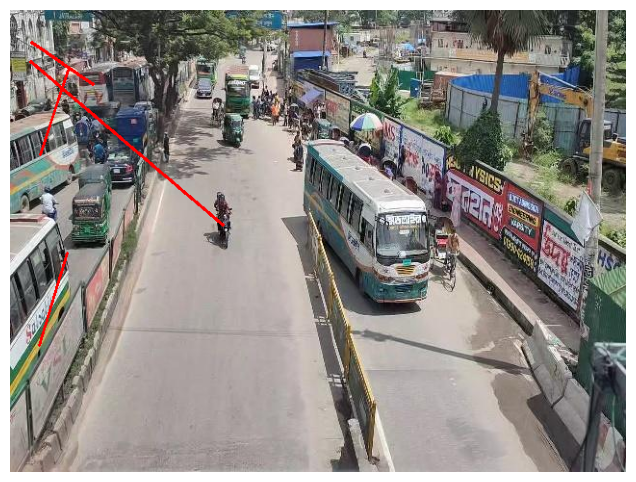

In [11]:
# ============================================================
# 10. Visualize Example Image with YOLO Annotations
# ============================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/kaggle/working/traffic_baseline/yolo_split/train/images/frame0_jpg.rf.1038d1fadaf090feae4bb9ac1aff7153.jpg"
label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

# Ensure the image exists before processing
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("✅ Image loaded successfully!")
    else:
        print("⚠️ Error: Image could not be loaded. Possible corruption:", img_path)
else:
    print("❌ Image path does not exist:", img_path)

# Read annotations if label exists
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    for line in lines:
        values = list(map(float, line.split()))
        class_id = int(values[0])
        polygon = values[1:]  # Polygon coordinates

        # Convert YOLO normalized coordinates to image points
        points = [(int(polygon[i] * img.shape[1]), int(polygon[i+1] * img.shape[0])) 
                  for i in range(0, len(polygon), 2)]
        
        # Draw polygon
        cv2.polylines(img, [np.array(points)], isClosed=True, color=(255, 0, 0), thickness=2)
else:
    print("⚠️ Label file does not exist:", label_path)

# Show image with annotations
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.show()


In [12]:
# ============================================================
# 11. Update `data.yaml` with Correct Paths and Classes
# ============================================================
import yaml

# Define the correct paths for your dataset
data_yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"  # Save in working directory

correct_paths = {
    "train": "/kaggle/working/traffic_baseline/yolo_split/train/images",  # Update this path
    "val": "/kaggle/working/traffic_baseline/yolo_split/val/images",      # Update this path
    "test": "/kaggle/working/traffic_baseline/yolo_split/test/images",    # Update this path
    "nc": 9,  # Number of classes
    "names": ['Rickshaw', 'Bus', 'Truck', 'Bike', 'Mini-truck', 'People', 'Car', 'CNG', 'Cycle']  # Class names
}

# Save the updated data.yaml
with open(data_yaml_path, "w") as file:
    yaml.dump(correct_paths, file, default_flow_style=False)

print(f"✅ Updated data.yaml saved at: {data_yaml_path}")


✅ Updated data.yaml saved at: /kaggle/working/traffic_baseline/data_traffic.yaml


In [13]:
# ============================================================
# 12. Load YOLOv12s Model
# ============================================================

model = YOLO("yolo12s.pt")
print("✅ YOLOv12 small pretrained model loaded successfully!")


✅ YOLOv12 small pretrained model loaded successfully!


In [14]:
# ============================================================
# 13. Clear GPU Cache Before Training
# ============================================================

import torch

torch.cuda.empty_cache()
print("✅ GPU cache cleared")


✅ GPU cache cleared


In [15]:
# ============================================================
# 14. Train YOLOv12s Model (Updated for Better Performance)
# ============================================================

import time

# Start time
start_time = time.time()

# Train the model with improved config
results = model.train(
    data='/kaggle/working/traffic_baseline/data_traffic.yaml',
    imgsz=640,
    epochs=50,
    batch=16,           # smaller batch may stabilize training
    name='yolo12s_exp1', # avoid overwriting original weights
    save_period=10,     # saves checkpoint every 10 epochs
    device='0,1',       # use both GPUs
    optimizer='AdamW',  # explicit optimizer
    lr0=0.0005,         # slight learning rate reduction
    weight_decay=0.0007, # slightly higher regularization
    patience=15         # early stopping if using Ultralytics auto features
)

# End time
end_time = time.time()
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = int(total_time % 60)

# Display training summary
print(f"✅ Training Completed!")
print(f"🕒 Time Taken: {minutes} min {seconds} sec")

# Safe way to get epochs if results.epochs is None
epochs_ran = results.epochs if results.epochs is not None else "Check runs/detect/<name>/results.csv"
print(f"🔄 Total Epochs: {epochs_ran}")
print(f"✅ Best weights saved at: runs/detect/yolo12s_exp1/weights/best.pt")


Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_baseline/data_traffic.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12s_exp1, nbs=64, nms=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2367      23256      0.618      0.655      0.658      0.423
              Rickshaw       1973       6142       0.77      0.721      0.805      0.518
                   Bus       1964       5184      0.711      0.843      0.834      0.563
                 Truck        112        121      0.287      0.405      0.301      0.231
                  Bike       1055       1545      0.677      0.741      0.772      0.433
                People       1449       3817      0.692      0.769      0.794      0.465
                   Car       2145       6370      0.793      0.871      0.907      0.658
                 Cycle         73         77      0.398      0.234      0.191     0.0924
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolo12s_exp1
✅ Training Completed!
🕒 Time Taken: 63 min 49 sec


AttributeError: 'NoneType' object has no attribute 'epochs'

In [16]:
# ============================================================
# 15. Inspect latest training run outputs (updated)
# ============================================================

import pandas as pd
import os, glob

# Get all run folders under /kaggle/working/runs/detect/
runs = sorted(glob.glob("/kaggle/working/runs/detect/*"), key=os.path.getmtime)

# Filter out empty folders (like 'val')
training_runs = [r for r in runs if os.path.exists(os.path.join(r, "weights")) and os.listdir(os.path.join(r, "weights"))]

if not training_runs:
    raise FileNotFoundError("No valid training runs found in /kaggle/working/runs/detect/")
    
# Pick the latest training run
run = training_runs[-1]
print("✅ Latest training run folder:", run)
print("📁 Contents:", os.listdir(run))

# Check results.csv
csv_path = os.path.join(run, "results.csv")
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("\n📊 Last 10 rows of results.csv:")
    display(df.tail(10))
else:
    print("⚠️ No results.csv found. Check the run folder:", run)

# List available weights
weights = glob.glob(os.path.join(run, "weights", "*.pt"))
if weights:
    print("\n💾 Weights found:", weights)
else:
    print("⚠️ No weights found in:", os.path.join(run, "weights"))


✅ Latest training run folder: /kaggle/working/runs/detect/yolo12s_exp1
📁 Contents: ['val_batch1_labels.jpg', 'BoxF1_curve.png', 'val_batch0_labels.jpg', 'val_batch2_pred.jpg', 'confusion_matrix.png', 'weights', 'args.yaml', 'confusion_matrix_normalized.png', 'val_batch0_pred.jpg', 'train_batch0.jpg', 'BoxR_curve.png', 'results.csv', 'labels.jpg', 'val_batch2_labels.jpg', 'train_batch2.jpg', 'train_batch10002.jpg', 'val_batch1_pred.jpg', 'train_batch1.jpg', 'BoxP_curve.png', 'BoxPR_curve.png', 'train_batch10001.jpg', 'train_batch10000.jpg', 'results.png']

📊 Last 10 rows of results.csv:


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
40     41  3111.14         0.97795         0.67587         1.00907   
41     42  3186.45         0.95182         0.64414         0.99870   
42     43  3261.97         0.94577         0.63482         0.99723   
43     44  3337.29         0.94338         0.62806         0.98928   
44     45  3412.17         0.93155         0.62165         0.99883   
45     46  3487.42         0.91783         0.60839         0.98561   
46     47  3562.65         0.90987         0.60274         0.98727   
47     48  3638.14         0.90486         0.59626         0.98200   
48     49  3713.11         0.88547         0.57960         0.97690   
49     50  3788.40         0.88768         0.57100         0.97297   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
40               0.60114            0.65343           0.65247   
41               0.60663            0.64080           0.64876   
42               0.58885            0.66779           0.65459   
43               0.62364            0.62240           0.64810   
44               0.62300            0.62242           0.65159   
45               0.58843            0.65858           0.65312   
46               0.61939            0.65470           0.65746   
47               0.60854            0.65524           0.65676   
48               0.62421            0.63989           0.65325   
49               0.63132            0.64355           0.65577   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
40              0.41601       1.23300       0.83067       1.07326  0.000104   
41              0.41401       1.23565       0.83233       1.07383  0.000094   
42              0.41832       1.23117       0.85158       1.07789  0.000084   
43              0.41276       1.23641       0.84706       1.07874  0.000074   
44              0.41867       1.22476       0.84626       1.07533  0.000064   
45              0.41730       1.23337       0.85086       1.07873  0.000055   
46              0.42286       1.22641       0.84964       1.07532  0.000045   
47              0.42076       1.22844       0.84370       1.07598  0.000035   
48              0.41781       1.23216       0.85663       1.07963  0.000025   
49              0.42126       1.22555       0.84825       1.07703  0.000015   

      lr/pg1    lr/pg2  
40  0.000104  0.000104  
41  0.000094  0.000094  
42  0.000084  0.000084  
43  0.000074  0.000074  
44  0.000064  0.000064  
45  0.000055  0.000055  
46  0.000045  0.000045  
47  0.000035  0.000035  
48  0.000025  0.000025  
49  0.000015  0.000015


💾 Weights found: ['/kaggle/working/runs/detect/yolo12s_exp1/weights/last.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/epoch40.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/epoch20.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/epoch30.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/best.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/epoch10.pt', '/kaggle/working/runs/detect/yolo12s_exp1/weights/epoch0.pt']


In [17]:
# ============================================================
# 16. Count class occurrences in training set (updated)
# ============================================================

from pathlib import Path
from collections import Counter
import yaml

# Load class names from data.yaml
yaml_path = "/kaggle/working/traffic_baseline/data_traffic.yaml"
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]

# Path to train labels
label_path = Path("/kaggle/working/traffic_baseline/yolo_split/train/labels")

# Count occurrences
labels = list(label_path.rglob("*.txt"))
cnt = Counter()
for f in labels:
    with open(f, "r") as file:
        for line in file:
            if line.strip():  # skip empty lines
                cls = int(line.split()[0])
                cnt[cls] += 1

# Print class counts with names
print("✅ Training Set Class Distribution:")
for cls_id, count in sorted(cnt.items()):
    cls_name = class_names[cls_id] if cls_id < len(class_names) else f"Class {cls_id}"
    print(f"{cls_name} (ID {cls_id}): {count} instances")


✅ Training Set Class Distribution:
Rickshaw (ID 0): 1740 instances
Bus (ID 1): 6096 instances
Truck (ID 2): 350 instances
Bike (ID 3): 1983 instances
People (ID 5): 3361 instances
Car (ID 6): 10052 instances
Cycle (ID 8): 85 instances


In [18]:
# ============================================================
# 17. ZIP the latest run folder/trained weights folder + copy to output folder
# ============================================================

import shutil
from pathlib import Path
import os, glob

# --- Find the latest run folder ---
runs = sorted(glob.glob("/kaggle/working/runs/detect/*"), key=os.path.getmtime)
if not runs:
    raise FileNotFoundError("❌ No run folders found in /kaggle/working/runs/detect/")

latest_run = runs[-1]
print("📌 Latest run folder:", latest_run)

# --- Prepare ZIP output paths ---
zip_working = "/kaggle/working/latest_run.zip"

# --- ZIP the entire run directory (original logic!) ---
shutil.make_archive(
    zip_working.replace(".zip", ""), 
    'zip', 
    latest_run
)
print(f"✅ ZIP created in working folder: {zip_working}")

# --- Also copy to /kaggle/output/ for easy download ---
output_folder = Path("/kaggle/output")
output_folder.mkdir(exist_ok=True)

zip_output = output_folder / "latest_run.zip"
shutil.copy(zip_working, zip_output)

print(f"📁 ZIP copied to output folder: {zip_output}")


📌 Latest run folder: /kaggle/working/runs/detect/yolo12s_exp1
✅ ZIP created in working folder: /kaggle/working/latest_run.zip
📁 ZIP copied to output folder: /kaggle/output/latest_run.zip


In [19]:
# ============================================================
# 18. Verify ZIP exists in output folder
# ============================================================

from pathlib import Path

zip_path = Path("/kaggle/output/latest_run.zip")
print("ZIP found:", zip_path.exists())


ZIP found: True


In [20]:
# ============================================================
# 19. Search for ZIP file in working & output folders
# ============================================================

from pathlib import Path

# Start searching from /kaggle/working and /kaggle/output
search_paths = ["/kaggle/working", "/kaggle/output"]

# Name of the file you are looking for
file_name = "latest_run.zip"   # updated zip name

# Search recursively
found_files = []
for path in search_paths:
    for f in Path(path).rglob(file_name):
        found_files.append(f.resolve())

if found_files:
    print("✅ Found the file at:")
    for f in found_files:
        print(f)
else:
    print("❌ File not found")


✅ Found the file at:
/kaggle/working/latest_run.zip
/kaggle/output/latest_run.zip


In [21]:
# ============================================================
# 20. Evaluate YOLOv12 model on your dataset
# ============================================================

from ultralytics import YOLO

# Correct path to best.pt from the latest training run
model_path = "/kaggle/working/runs/detect/yolo12s_exp1/weights/best.pt"

# Load the trained YOLO model
model = YOLO(model_path)

# Run validation on your dataset
metrics = model.val(data="/kaggle/working/traffic_baseline/data_traffic.yaml")

# Print full evaluation metrics
print("\n📊 Full YOLO Model Evaluation Report:")
print(metrics)


Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1699.3±428.2 MB/s, size: 62.3 KB)
val: Scanning /kaggle/working/traffic_baseline/yolo_split/val/labels.cache... 2367 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2367/2367 4.2Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 148/148 4.6it/s 32.2s0.2ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2367      23256      0.617      0.655      0.658      0.423
              Rickshaw       1973       6142       0.77      0.721      0.805      0.518
                   Bus       1964       5184      0.711      0.843      0.834      0.564
                 Truck        112        121      0.287      0.405      0.299       0.23
                  Bike       1055       1545      0.677      0.741      0.772      0.432
                People       1449       3817      0.691       0.77      0.794      0.465
                   Car       2145       6370      0.793      0.871      0.907      0.659
                 Cycle         73         77      0.389      0.234      0.191     0.0916
Speed: 0.6ms preprocess, 9.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

📊 Full YOLO Model Evaluation Report:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultraly

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


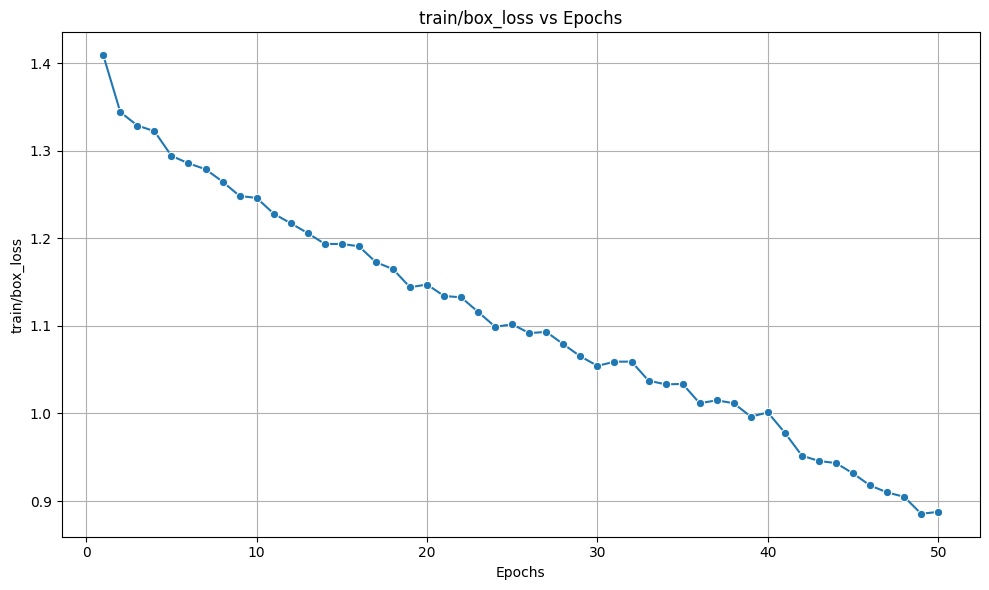

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


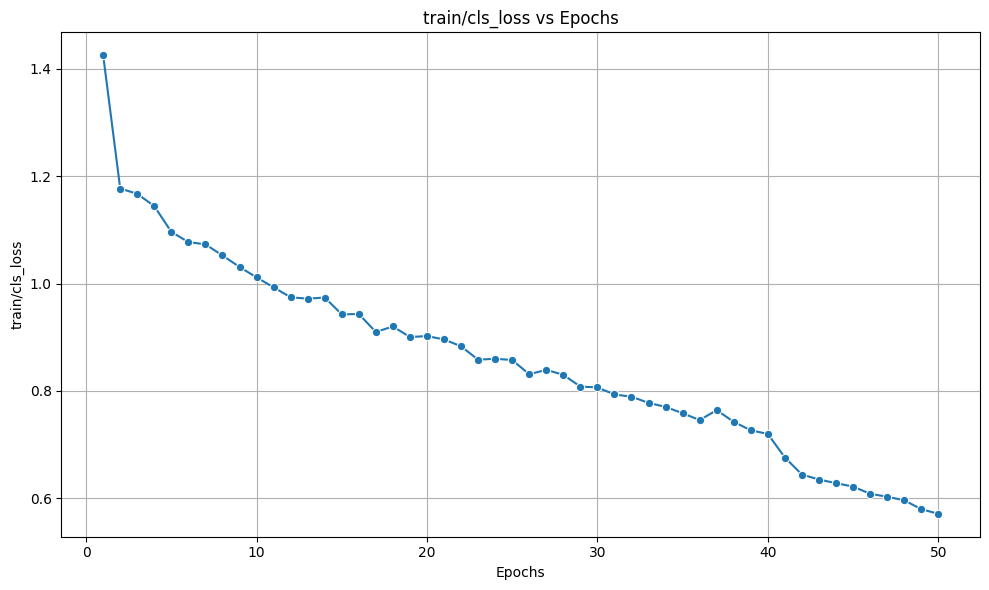

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


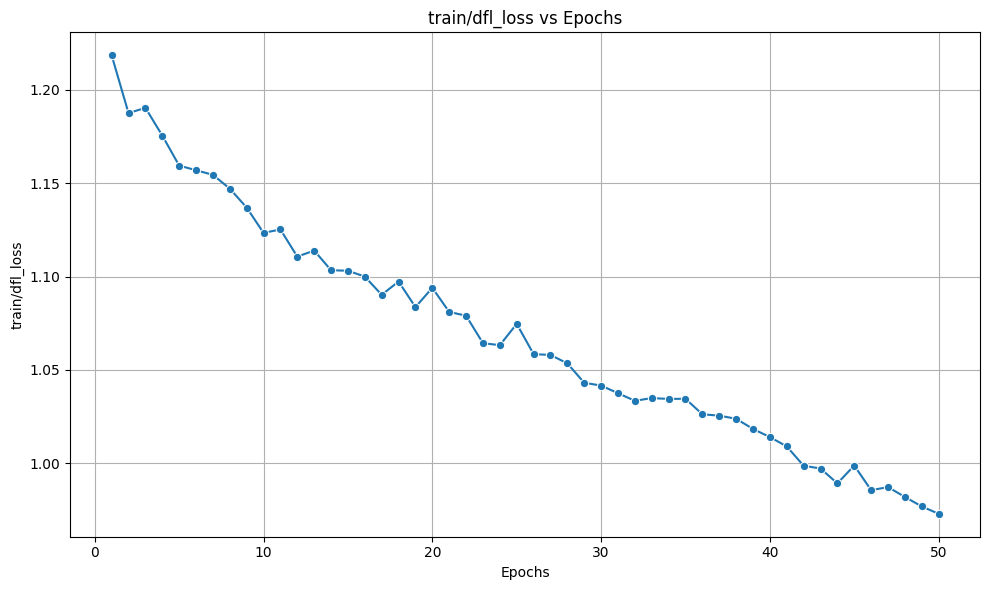

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


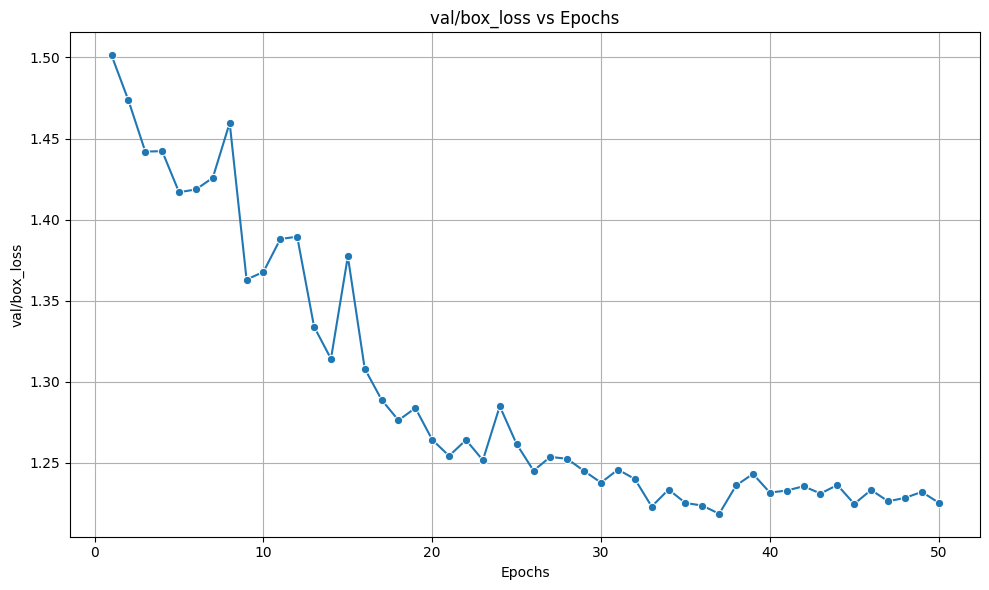

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


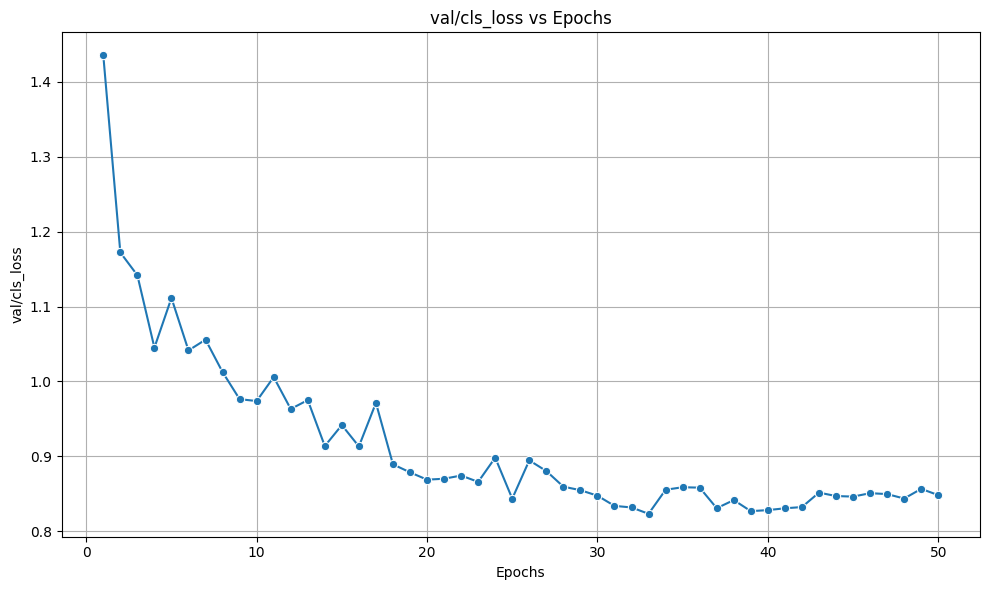

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


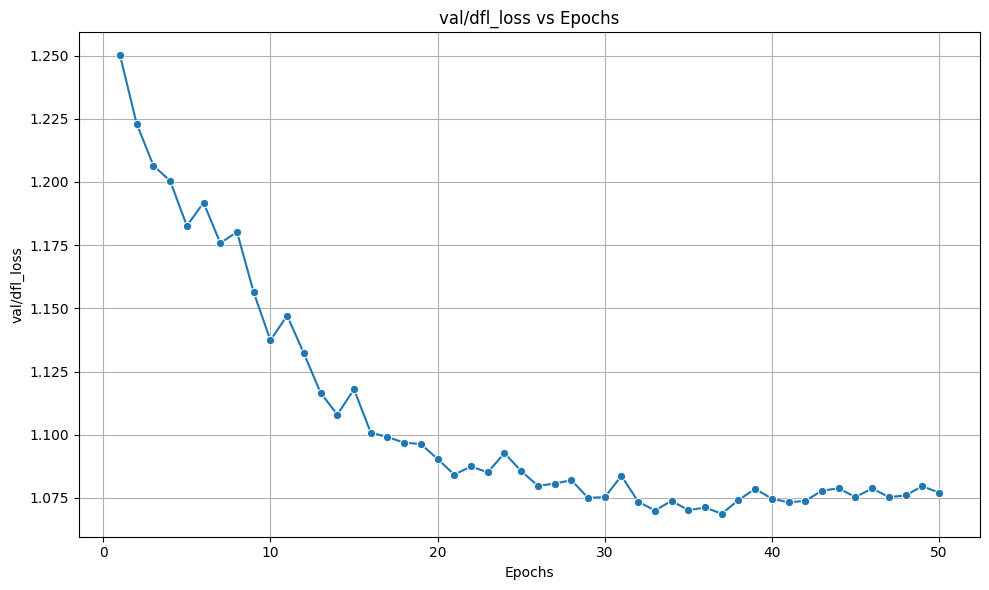

In [22]:
# ============================================================
# 21. Plot YOLOv12s Training & Validation Loss Metrics
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Path to the results.csv from latest training run
results_csv = Path("/kaggle/working/runs/detect/yolo12s_exp1/results.csv")

# Load the CSV
df = pd.read_csv(results_csv)

# Metrics to plot
metrics = ['train/box_loss','train/cls_loss','train/dfl_loss',
           'val/box_loss','val/cls_loss','val/dfl_loss']

# Plot each metric vs epoch
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epoch', y=metric, data=df, marker="o")
    plt.title(f"{metric} vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Evaluate**

In [23]:
#Locate where validation images are saved

from pathlib import Path

runs = sorted(Path("/kaggle/working/runs/detect").glob("*"), key=os.path.getmtime)
for r in runs:
    print(r, "->", list(r.glob("*.png"))[:3])


/kaggle/working/runs/detect/yolo12s_exp1 -> [PosixPath('/kaggle/working/runs/detect/yolo12s_exp1/BoxF1_curve.png'), PosixPath('/kaggle/working/runs/detect/yolo12s_exp1/confusion_matrix.png'), PosixPath('/kaggle/working/runs/detect/yolo12s_exp1/confusion_matrix_normalized.png')]
/kaggle/working/runs/detect/val -> [PosixPath('/kaggle/working/runs/detect/val/BoxF1_curve.png'), PosixPath('/kaggle/working/runs/detect/val/confusion_matrix.png'), PosixPath('/kaggle/working/runs/detect/val/confusion_matrix_normalized.png')]


In [24]:
# ================================================================
# Cell 22: Collect all validation/prediction images (.png, .jpg)
# ================================================================

from pathlib import Path
import os

# Find latest run folder with PNG/JPG images
runs = sorted(Path("/kaggle/working/runs/detect").glob("*"), key=os.path.getmtime, reverse=True)

paths2 = []
for r in runs:
    img_files = list(r.glob("*.png")) + list(r.glob("*.jpg"))
    if img_files:  # stop at the first folder containing images
        paths2 = sorted([str(f) for f in img_files])
        run_folder = r
        break

print(f"✅ Total images found: {len(paths2)}")
print(f"📌 First 3 image paths: {paths2[:3]}")
print(f"📂 Images are from folder: {run_folder}")


✅ Total images found: 12
📌 First 3 image paths: ['/kaggle/working/runs/detect/val/BoxF1_curve.png', '/kaggle/working/runs/detect/val/BoxPR_curve.png', '/kaggle/working/runs/detect/val/BoxP_curve.png']
📂 Images are from folder: /kaggle/working/runs/detect/val


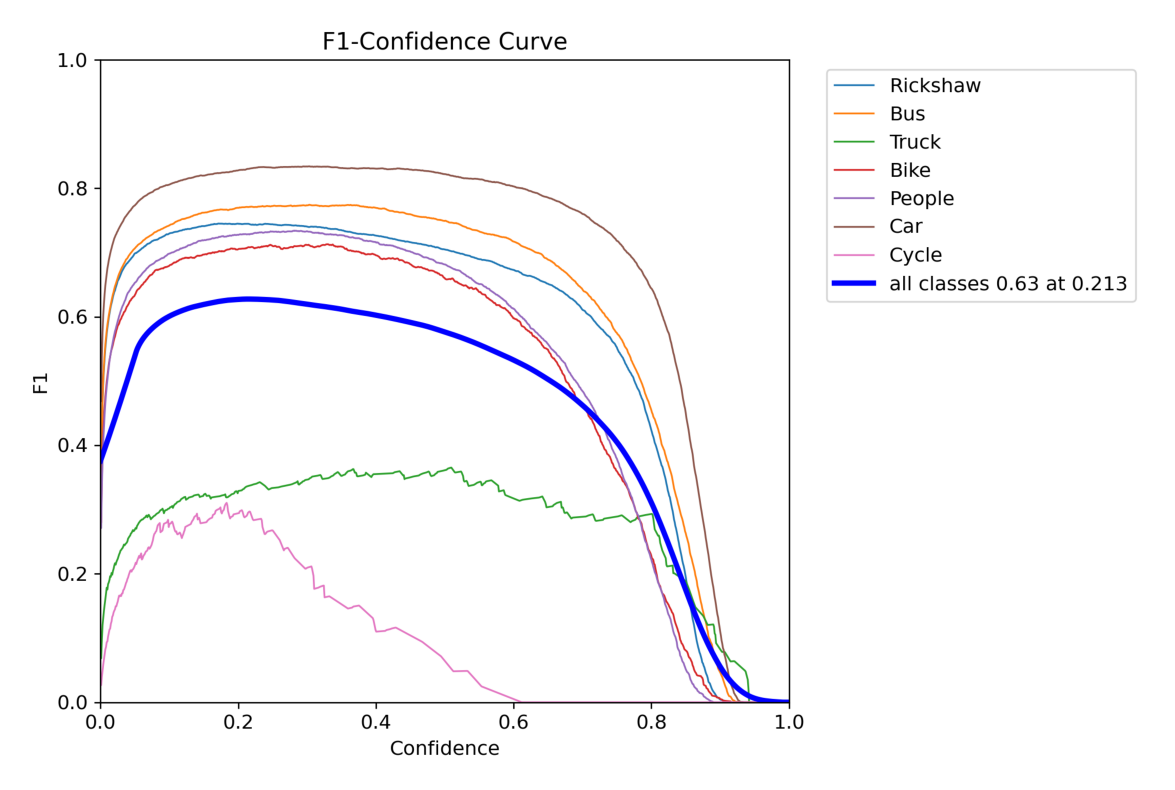

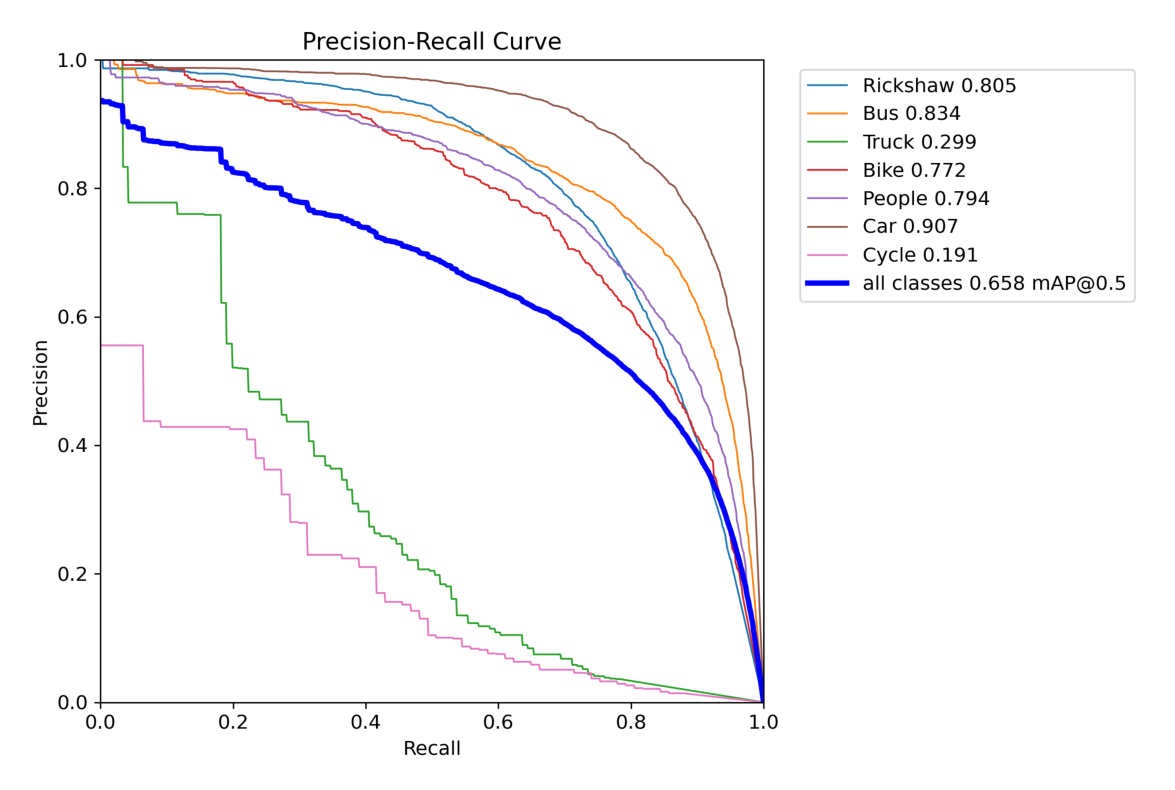

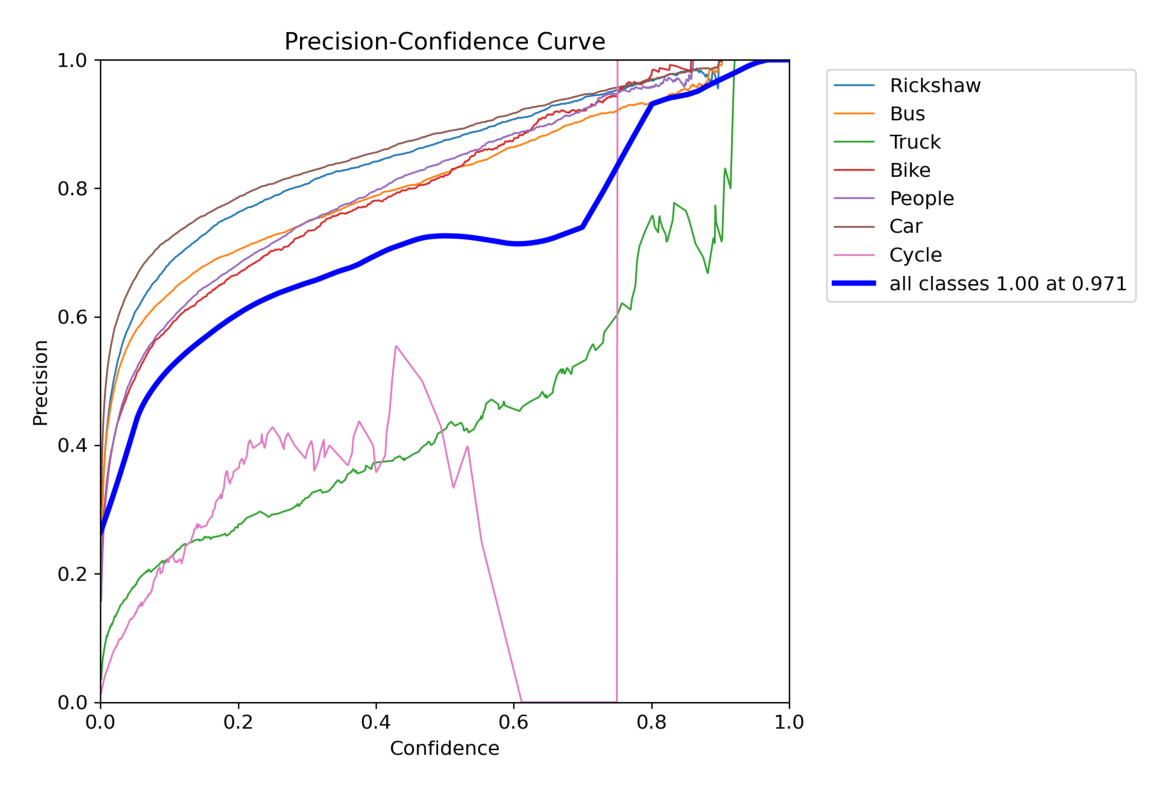

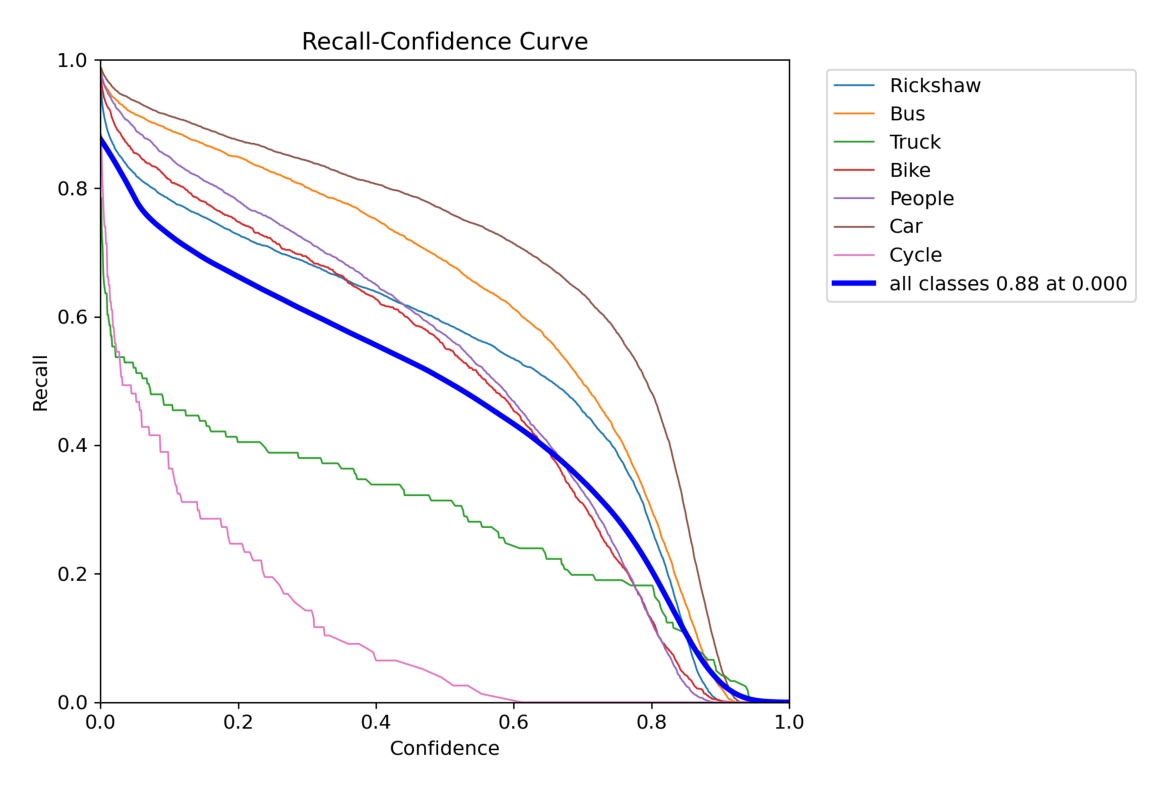

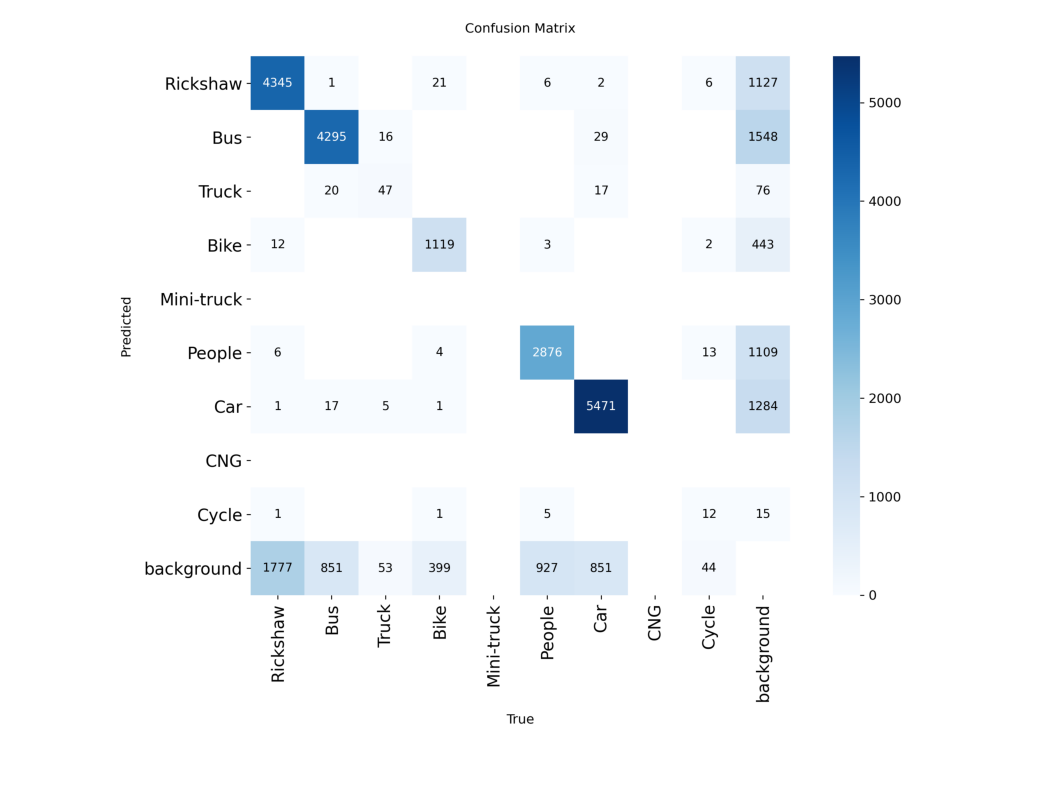

In [25]:
# ==============================
# Cell 23: Display first few prediction/validation images
# ==============================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Display images
for path in paths2[:5]:  # limit to first 5 images for quick display
    image = Image.open(path)
    image = np.array(image)
    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [26]:
# ============================================================
# Cell 24: Evaluate on test set + generate plots
# ============================================================

from ultralytics import YOLO
from pathlib import Path

# Ensure DATA and OUTPUT_FOLDER paths are defined
DATA = Path("/kaggle/working/traffic_baseline/data_traffic.yaml")  # your dataset config
OUTPUT_FOLDER = Path("/kaggle/working/runs/detect/yolo12s_exp1")     # output folder

# Evaluate the trained model on the test split and generate plots
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,               # generate plots like PR, confusion matrix
    project=str(OUTPUT_FOLDER),  # save outputs in the same folder
    name="val"                 # subfolder name for this validation run
)

# Print main evaluation metrics
print("📊 Test Set Metrics:")
print("mAP@0.5     :", metrics.box.map50)
print("mAP@[0.5:0.95]:", metrics.box.map)
print("Precision   :", metrics.box.mp)
print("Recall      :", metrics.box.mr)


Ultralytics 8.3.239 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1364.5±160.0 MB/s, size: 72.4 KB)
val: Scanning /kaggle/working/traffic_baseline/yolo_split/test/labels... 2369 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2369/2369 1.4Kit/s 1.6s0.0s
val: New cache created: /kaggle/working/traffic_baseline/yolo_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 149/149 4.4it/s 34.1s0.2ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2369      23199      0.607       0.68      0.681      0.441
              Rickshaw       1968       6041      0.744      0.744      0.811      0.519
                   Bus       1958       5158      0.692      0.856      0.842      0.568
                 Truck        100        120       0.36      0.475      0.424      0.337
                  Bike       1071       1630      0.683      0.764      0.783      0.446
                People       1460       3872      0.673      0.806      0.809      0.478
                   Car       2136       6294      0.771       0.88      0.906      0.651
                 Cycle         80         84      0.326      0.236      0.194     0.0894
Speed: 0.6ms preprocess, 9.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolo12s_exp1/val
📊 Test Set Metrics:
mAP@0.5     : 0.6812295185701268
mAP@[0.5:0.95]: 0.44130388608651794
Precision   : 0.6072109710570971
Recall      : 0.680130

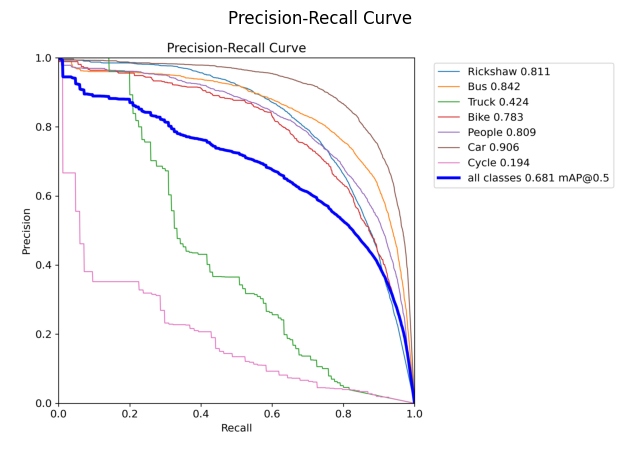

In [27]:
# ============================================================
# Cell 25: Visualize PR curve from custom folder
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# PR curve file path from the last evaluation run
pr_curve_file = list((OUTPUT_FOLDER / "val").glob("*PR_curve*.png"))[0]

# Load and display the image
img = mpimg.imread(pr_curve_file)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Precision-Recall Curve")
plt.show()


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   79.8781         1.40900         1.42519         1.21860   
1      2  157.0240         1.34408         1.17690         1.18761   
2      3  232.9420         1.32880         1.16709         1.19043   
3      4  309.2880         1.32229         1.14415         1.17561   
4      5  385.1430         1.29415         1.09609         1.15950   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.59290            0.48220           0.49466   
1               0.66056            0.48801           0.54354   
2               0.61975            0.53661           0.53131   
3               0.66561            0.56300           0.57668   
4               0.67071            0.53300           0.56592   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.26289       1.50132       1.43559       1.25012  0.066966   
1              0.28981       1.47355  

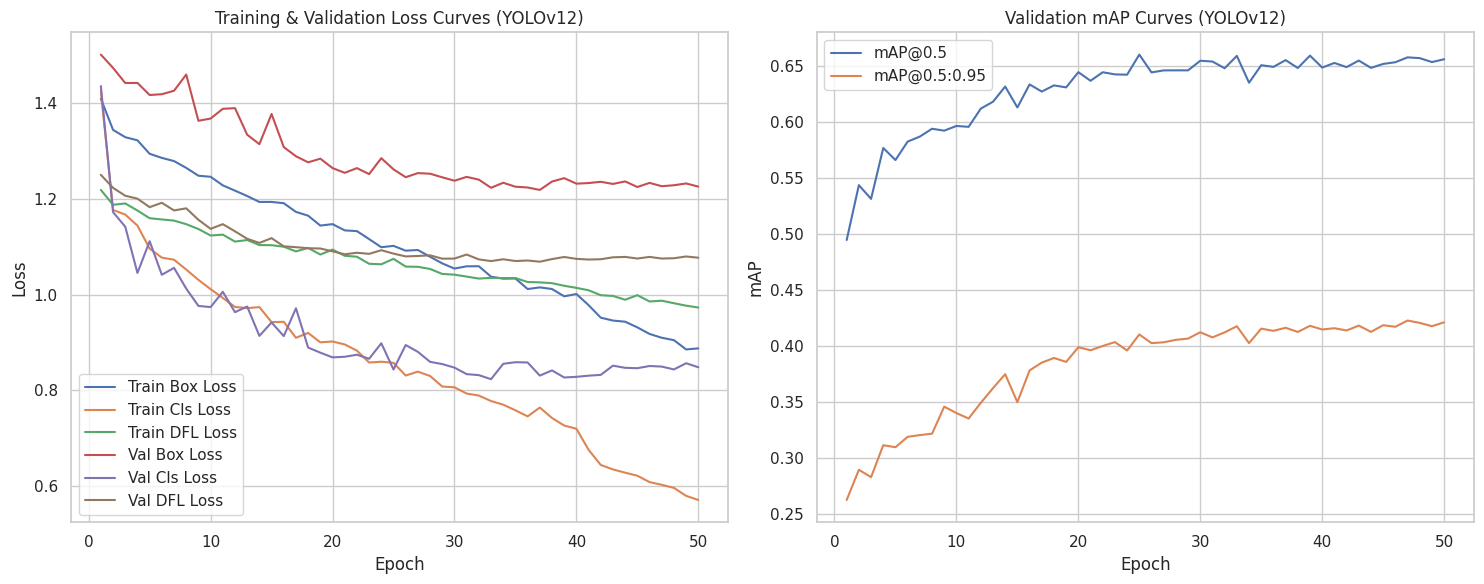

In [28]:
# ============================================================
# 26. Visualize Training & Validation Metrics
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ✅ Load YOLOv12 results CSV
df = pd.read_csv("/kaggle/working/runs/detect/yolo12s_exp1/results.csv")

# Show first few rows to confirm available columns
print(df.head())

# Set seaborn style
sns.set(style="whitegrid")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# --- 1️⃣ Plot Training & Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curves (YOLOv12)')
plt.legend()
plt.grid(True)

# --- 2️⃣ Plot mAP curves (mean Average Precision) ---
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP Curves (YOLOv12)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   79.8781         1.40900         1.42519         1.21860   
1      2  157.0240         1.34408         1.17690         1.18761   
2      3  232.9420         1.32880         1.16709         1.19043   
3      4  309.2880         1.32229         1.14415         1.17561   
4      5  385.1430         1.29415         1.09609         1.15950   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.59290            0.48220           0.49466   
1               0.66056            0.48801           0.54354   
2               0.61975            0.53661           0.53131   
3               0.66561            0.56300           0.57668   
4               0.67071            0.53300           0.56592   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.26289       1.50132       1.43559       1.25012  0.066966   
1              0.28981       1.47355  

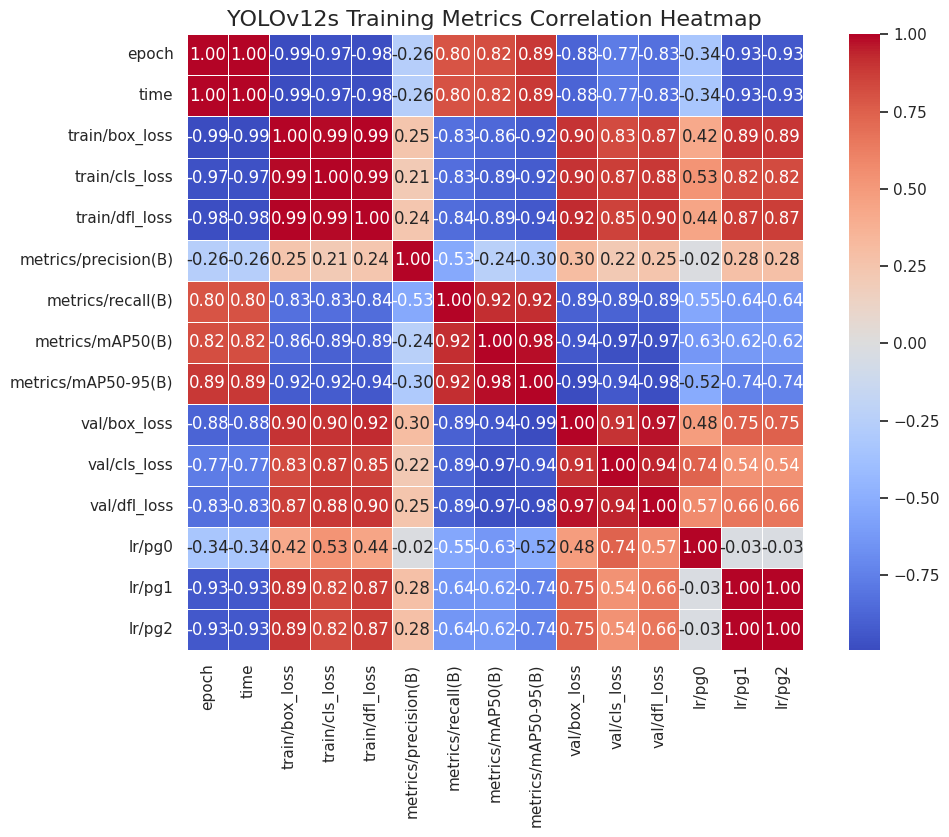

In [29]:
# ============================================================
# 27. Correlation Heatmap of YOLOv12s Training Metrics
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load YOLOv12s training results CSV
df = pd.read_csv("/kaggle/working/runs/detect/yolo12s_exp1/results.csv")

# Display first few rows to confirm it's loaded
print(df.head())

# Compute correlation matrix of all numeric metrics
corr = df.corr()

# Set figure size
plt.figure(figsize=(12, 8))

# Create correlation heatmap
sns.heatmap(
    corr,
    annot=True,        # Show correlation values
    cmap='coolwarm',   # Color map
    fmt=".2f",         # Decimal format
    linewidths=0.5,    # Lines between cells
    square=True
)

# Add title
plt.title("YOLOv12s Training Metrics Correlation Heatmap", fontsize=16)

# Display the plot
plt.show()



image 1/1 /kaggle/working/traffic_baseline/yolo_split/test/images/frame13_jpg.rf.4ae240069e5f4f91d32a83d59ae24652.jpg: 480x640 4 Buss, 1 People, 1 Car, 56.7ms
Speed: 1.5ms preprocess, 56.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


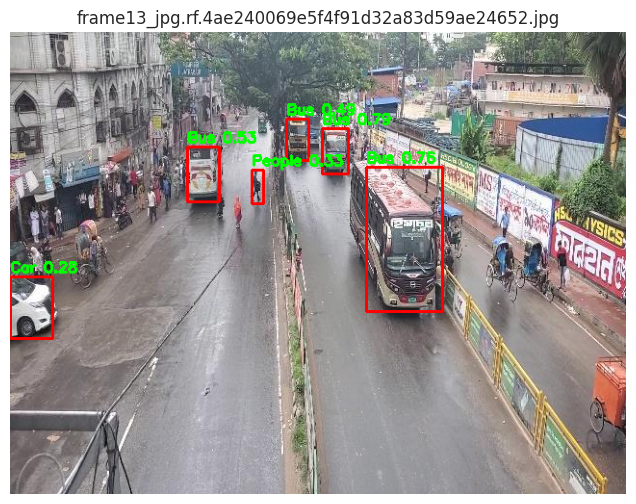


image 1/1 /kaggle/working/traffic_baseline/yolo_split/test/images/frame338_jpg.rf.87acecc249a1afaf30a8a0389e4c42a9.jpg: 480x640 1 Bus, 1 Bike, 1 People, 3 Cars, 21.7ms
Speed: 1.6ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


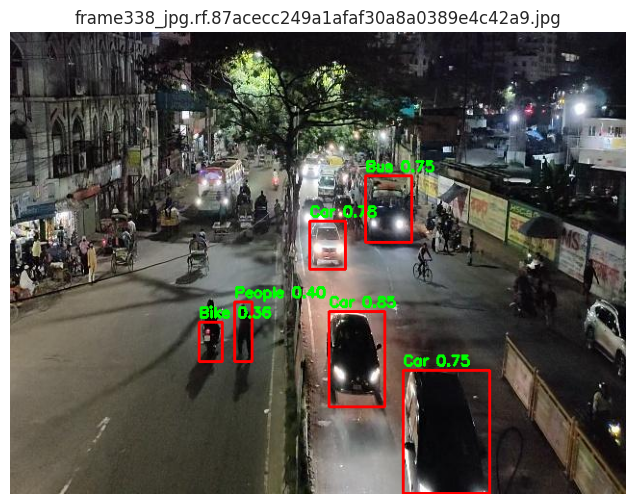


image 1/1 /kaggle/working/traffic_baseline/yolo_split/test/images/frame577_jpg.rf.80b178d15b5f81b32874f908dde3698e.jpg: 480x640 4 Rickshaws, 3 Buss, 1 Bike, 3 Peoples, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


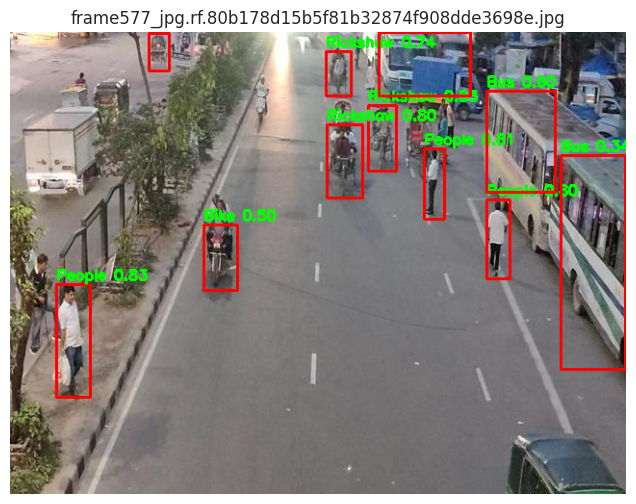


image 1/1 /kaggle/working/traffic_baseline/yolo_split/test/images/frame37_jpg.rf.7bca4b355c69a1959fbb12a7d4e23039.jpg: 480x640 2 Buss, 1 Bike, 2 Cars, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


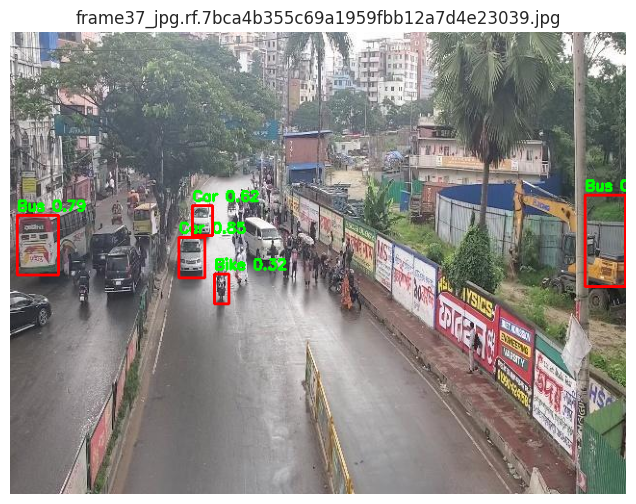


image 1/1 /kaggle/working/traffic_baseline/yolo_split/test/images/frame19_jpg.rf.1651e41b699329f2be77af5bad664240.jpg: 480x640 2 Buss, 2 Cars, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


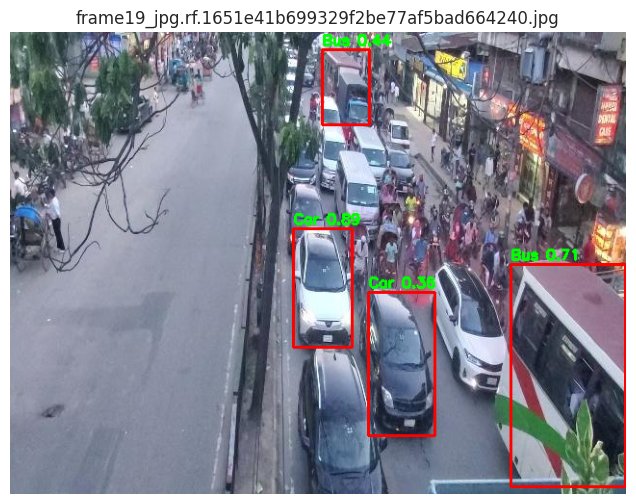

In [30]:
# ============================================================
# 28. Visualize YOLOv12s detections with labels on sample images
# ============================================================

from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from pathlib import Path

# Load trained YOLOv12s model
model = YOLO("/kaggle/working/runs/detect/yolo12s_exp1/weights/best.pt")

# Folder with test images (adjust path to your images)
test_images_folder = Path("/kaggle/working/traffic_baseline/yolo_split/test/images")
images = list(test_images_folder.glob("*.jpg")) + list(test_images_folder.glob("*.png"))

# Pick a few random images to display
sample_images = random.sample(images, min(5, len(images)))

for img_path in sample_images:
    # Run detection
    results = model.predict(img_path, conf=0.25, show=False)  # conf threshold can be adjusted
    result = results[0]  # get first (and only) image result
    
    # Load image
    image = np.array(Image.open(img_path))
    
    # Draw bounding boxes and labels
    for box, cls_id, score in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        x1, y1, x2, y2 = map(int, box)
        label = f"{model.names[int(cls_id)]} {score:.2f}"
        # Draw rectangle
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)
        # Draw label text
        image = cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    # Display the image
    plt.figure(figsize=(12,6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(img_path.name)
    plt.show()
